# Blockchain Data Analysis: Exploring transactions between miners in Ethereum

One of the most contentious issues in the Blockchain space concerns the independence and stability of the transaction validators that participate in the consensus protocol. In Proof-of-Work (PoW) Blockchains these _validators_ are called **miners**. The specialization and centralization of mining across different PoW systems has been well documented in the last few years. High centralization of mining, undermines the central premise of blockchain systems by making the system: 
1. more vulnerable to central points of failure and 
2. more vulnerable to the larger miners manipulating transactions on their behalf (see [Selfish Mining](https://www.binance.vision/glossary/selfish-mining), [51% Attacks](https://www.binance.vision/security/what-is-a-51-percent-attack) and [Transaction Frontrunning](https://arxiv.org/pdf/1904.05234.pdf)). 

Eventhough the individual mining power can be readily observed by looking at how many blocks has each miner mined, there might still exist collusion agreements or other types of relationships between miners, that are less aparent. This notebook intents to explore transactions between miners in Ethereum to try to characterize potential relationships between miners. 

In the notebook you will: 


- Explore the evolution of the Etheruem mining ecosystem
- Pre-process data to create a transaction graph object
- Visualize transaction graph data
- Perform basic network analysis over the transaction graph

This notebook assumes basic understanding of [numpy arrays](https://cs231n.github.io/python-numpy-tutorial/#arrays) and [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/getting_started/dsintro.html) data structures. 

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore
import os
import random

## Part 1: Exploring the evolution of the Ethereum miner ecosystem

In the ./data folder of our repo, we have compiled 51 snapshots of the Ethereum miner transaction network that cover transactions in 8,863,264 blocks (since the launch of Ethereum in July 30 2015 to November 3 2019). Each snapshot is stored as a Pandas DataFrame that aggregates blocks mined in increments of 170,822 blocks (roughly the number of blocks mined every month). All snapshots are stored in a list of DataFrames. The data is extracted below

In [3]:
# LOAD DATACreate dataframes from CSV files
for (root,dirs,files) in os.walk(
    './data/miner_volume', topdown=True):
    files_list=files
    root_dir=root
file_path_list=[root_dir+'/'+file for file in files_list]
file_path_list.sort()

miner_summaries=[pd.read_csv(file_path).drop(columns='Unnamed: 0') for file_path in file_path_list] #Load each summary (slice) in list

for df in miner_summaries: # Edit miners with null blocks
    df.loc[df['block'].isnull(),'block']=1
# Final list with miner summary dataframes

For example the first 5 rows of the DataFrame for the 5th snapshot are shown below. This DataFrame aggregates information for the first 854,110 (170,822 x 5) blocks: 
- **miner**: The miner's public address. 
- **block**: The number of blocks mined by that miner up until block 854,110
- **transaction_count**: The number of transactions mined by that miner up until block 854,110

In [5]:
miner_summaries[5].head()

,miner,block,transaction_count
0,0x52bc44d5378309ee2abf1539bf71de1b7d7be3b5,223013,384665
1,0x2a65aca4d5fc5b5c859090a6c34d164135398226,156791,391053
2,0xf8b483dba2c3b7176a3da549ad41a48bb3121069,88599,173344
3,0x1dcb8d1f0fcc8cbc8c2d76528e877f915e299fbe,41733,49903
4,0x63a9975ba31b0b9626b34300f7f627147df1f526,40970,59815


### Concetration of mining

Let's look at the evolution of the aggregate number of miners and transactions evolved in the network with respect to the total number of transactions validated (mined). Run the cell below to plot a graph that shows this comparisson.

Text(0, 0.5, 'Transactions mined')

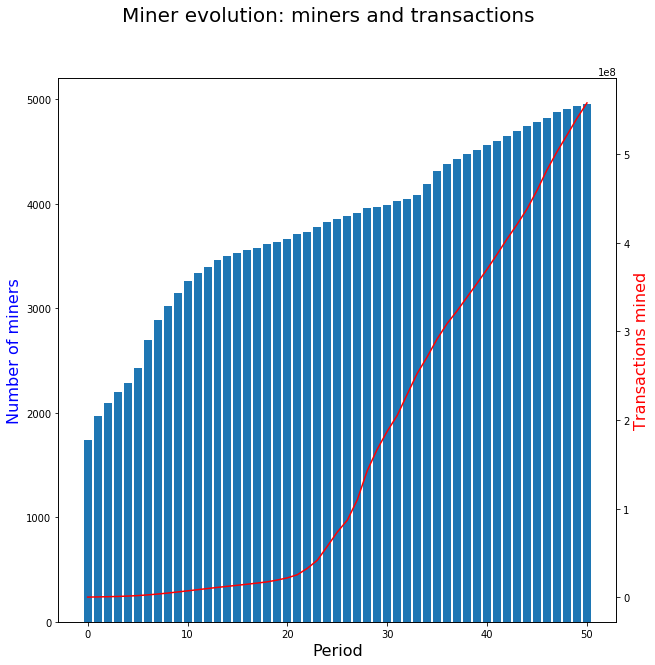

In [6]:
# Create series with number of miners and transactions
no_miners=[len(miner_summary) for miner_summary in miner_summaries]
no_transactions=[miner_summary['transaction_count'].sum() for miner_summary in miner_summaries]

# Plot
y_pos = np.arange(len(no_miners))
fig,ax=plt.subplots(figsize=(10,10))

ax1 = ax.twinx()
fig.suptitle('Miner evolution: miners and transactions',fontsize=20)

ax.bar(y_pos,no_miners)
ax1.plot(no_transactions,color='r')

ax.set_xlabel('Period',fontsize=16)
ax.set_ylabel('Number of miners', color='b',fontsize=16)
ax1.set_ylabel('Transactions mined', color='r',fontsize=16)


Plot a similar graph that shows how the number of blocks mined and the number of miners have evolved over the 50 periods. 

Text(0, 0.5, 'Number of blocks mined')

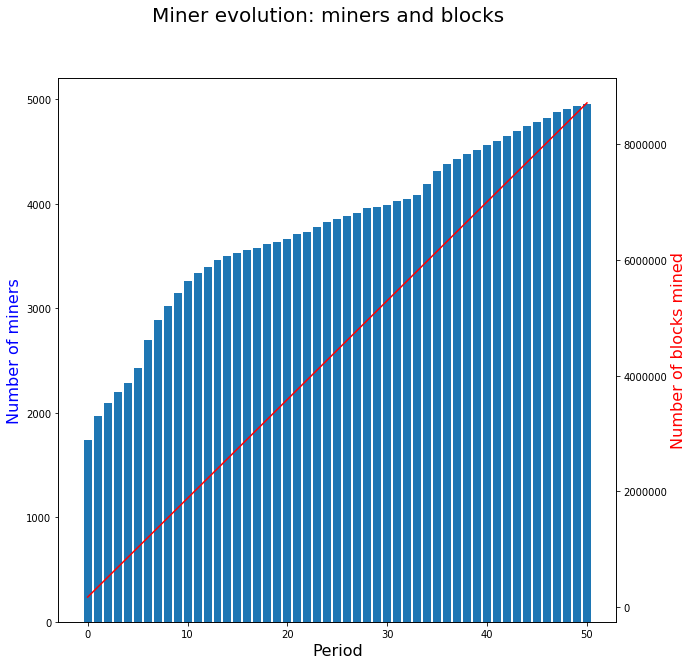

In [7]:
# Create series with number of miners and transactions
no_miners=[len(miner_summary) for miner_summary in miner_summaries]
no_transactions=[miner_summary['block'].sum() for miner_summary in miner_summaries]

# Plot
y_pos = np.arange(len(no_miners))
fig,ax=plt.subplots(figsize=(10,10))

ax1 = ax.twinx()
fig.suptitle('Miner evolution: miners and blocks',fontsize=20)

ax.bar(y_pos,no_miners)
ax1.plot(no_transactions,color='r')

ax.set_xlabel('Period',fontsize=16)
ax.set_ylabel('Number of miners', color='b',fontsize=16)
ax1.set_ylabel('Number of blocks mined', color='r',fontsize=16)


**QUESTION 1**: Give one reason that explains why the growth rate in the number of blocks mined is different from the growth rate of the number of transactions mined. 

We can clearly see that the aggregate number of miners has grown slower than the aggregate number of transactions validated, meaning that as the Ethereum Blockchain has progressed, on average each miner must be validating more transactions. Let's take a look at how the proportion of blocks mined by the the top 10 miners (in terms of blocks mined), has evolved over time. Every snapshot has the miners ordered by the number of blocks they have mined. 

Below we will create a list with the mining share for each miner over the 50 periods

In [9]:
# Extract addresses for top 10 miners

top10_miners=miner_summaries[-1].iloc[:10,:]['miner'] # Addresses for top 10 miners

# Create a list of lists for each miner to track their mining share across periods 

top10_per_list=[] 
for miner in top10_miners:
    miner_per_list=[]
    for summary in miner_summaries:
        try: 
            blocks_mined=summary.loc[summary['miner']==miner]['block'].values[0]
        except IndexError: # Catch error if miner has not appeared in slice
            blocks_mined=0 

        miner_share=blocks_mined/summary['block'].sum()
        miner_per_list.append(miner_share)
                   
        
    top10_per_list.append(miner_per_list)


(0, 1)

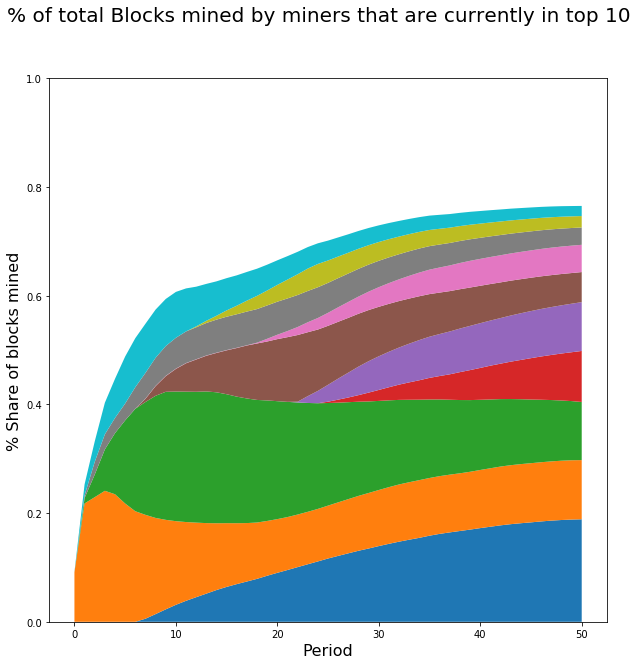

In [10]:

# Stack Plot
fig,ax=plt.subplots(figsize=(10,10))
fig.suptitle('% of total Blocks mined by miners that are currently in top 10',fontsize=20)

x=np.arange(len(miner_summaries))
ax.stackplot(x, *top10_per_list)

ax.set_xlabel('Period',fontsize=16)
ax.set_ylabel('% Share of blocks mined',fontsize=16)
ax.set_ylim(0,1)

We can see that the top 10 miners, ever since roughly the 5th period (approximately the 5th month), have mined more than 50% of the blocks in Ethereum. We can see the top 10 miners below

In [11]:
miner_summaries[50].head(-10)

,miner,block,transaction_count
0,0xea674fdde714fd979de3edf0f56aa9716b898ec8,1642881,153896019
1,0x52bc44d5378309ee2abf1539bf71de1b7d7be3b5,948543,65855756
2,0x2a65aca4d5fc5b5c859090a6c34d164135398226,931602,18882620
3,0x5a0b54d5dc17e0aadc383d2db43b0a0d3e029c4c,817632,92219325
4,0x829bd824b016326a401d083b33d092293333a830,782290,87711811
...,...,...,...
4937,0xbab073aeee288295ec7f6a85cab325af581f52fa,1,22
4938,0xba86dadd49ca8488b7a6c023fbc2308abe7800a5,1,19
4939,0xb9de07a49c10859d759a171f05997665e359a4e3,1,0
4940,0xba7d86b2ce814acd7f1e4b69ce87cddd5b1ec70a,1,0


Which miner has lost the most 'mining share' between period 10 and 50? 

In [12]:
differences=[]
for miner in top10_per_list:
    difference_i=miner[50]-miner[10]
    differences.append(difference_i)
min_gain_miner=np.array(differences).argmin()
print(miner_summaries[50].iloc[min_gain_miner]['miner'])    
    

0x2a65aca4d5fc5b5c859090a6c34d164135398226


**Question 2**: What is the 'public' name of the miner (mining operation) found in the previous question? (**hint**: Use the miners address and look it up in your favorite block explorer (eg. [Etherscan](https://etherscan.io/))

## Part 3: Pre-processing -> Graph definition

In this part we're going to pre-process data in a format that is suitable to create a NetworkX Graph object. NetworkX is a library that provides a large array of Network Analysis functions. 

**Miner transaction graph**

For this example we're going to create a directed weighted graph as follows: 

- Every node in our graph will a miner that has mined a block within our period of analysis (up to block no. 8,863,264). 
- For every pair of nodes _u_ and _v_ we will define an edge _(u,v)_ if there has been at least one transaction from _u_ and _v_. 
- We will assign every edge _(u,v)_ a weight corresponding to the total value (in USD) transacted from node _u_ to node _v_

**Data**

The whole transaction table from BiqQuery for our period of analysis weights more than 250GB, so we went ahead and extracted only the transactions between miners and summarized in the miners_transactions numpy array. This array contains edges between nodes for every snapshot but we will only be looking at the final snapshot for  this section. We also load a more complete version of the final snapshot of miner sumaries on the DataFrame miners.

In [13]:
# Load the final snapshot of edges

miners=pd.read_csv('./data/miners_summary.csv')
miners['miner_id']=miners.index
miners_transactions=np.load('./data/miners_trans_evolution_usd.npy',allow_pickle=True)[-1]

# Add miner id and change index
miners['miner_id']=miners.index #Use index of sorted dataframe (ranking) as miner_id
miners=miners.rename(columns={"count": "no. blocks", "sum": "no. transactions","nunique": "unique tags",'max':'miner_tag'})

# Additional transformations for edge calculations
miners.set_index('miner',inplace=True) #Set address as index
miners['miner']=miners.index
miners.head()


,no. blocks,no. transactions,unique tags,miner_tag,miner_id,miner
miner,,,,,,
0xea674fdde714fd979de3edf0f56aa9716b898ec8,1677231.0,158881295.0,137.0,×\nGethgo1.5.1 linux,0,0xea674fdde714fd979de3edf0f56aa9716b898ec8
0x52bc44d5378309ee2abf1539bf71de1b7d7be3b5,961958.0,66720193.0,33.0,Ü,1,0x52bc44d5378309ee2abf1539bf71de1b7d7be3b5
0x2a65aca4d5fc5b5c859090a6c34d164135398226,933307.0,19097355.0,24.0,×Gethgo1.6.2 linux,2,0x2a65aca4d5fc5b5c859090a6c34d164135398226
0x5a0b54d5dc17e0aadc383d2db43b0a0d3e029c4c,861883.0,96817057.0,116.0,ÞParity-Ethereum1.36.0li,3,0x5a0b54d5dc17e0aadc383d2db43b0a0d3e029c4c
0x829bd824b016326a401d083b33d092293333a830,799757.0,89240980.0,901.0,ä¸å½©ç¥ä»é±¼ÿû®,4,0x829bd824b016326a401d083b33d092293333a830


In [14]:
miners.iloc[10, :]

no. blocks                                              154185
no. transactions                                        504056
unique tags                                                  2
miner_tag                                                 Õ
miner_id                                                    10
miner               0xc0ea08a2d404d3172d2add29a45be56da40e2949
Name: 0xc0ea08a2d404d3172d2add29a45be56da40e2949, dtype: object

Create list of nodes. Given that each address is 20bytes long and we want our graph to be small and provide easily interpretable results, we will want to change the node id, from being the address to something else. For this section will use as node id, the index from the dataframe in the last snapshot. Create a list containing all node ids.

In [15]:
nodes=list(miners['miner_id'])

Each entry of the miners_transactions array above sumarizes transactions for a pair of addresses in the form \[\[address1\]\[address2\],value_transacted,number_of_transactions\]. The following block of code splits transactions into separate addresses and looks for the miner id in the miners DataFrame, to create a list of tuples of the form (address1_id,address2_id) for each transaction pair. 

In [16]:
# Transform concatenation into tuple of miner ids
# Extract array
address_ex=miners_transactions[:,0] 
address_ex=address_ex.astype(np.str)

# Split strings into two separate lists: join_list_0 and join_list_1
split_ad=np.char.rpartition(address_ex,'0x')
split_ad_m=np.split(split_ad,[1,2],axis=1) 
join=np.core.defchararray.add(split_ad_m[1],split_ad_m[2])
join_0=np.squeeze(split_ad_m[0])
join_list_0=[miners.miner_id[address] for address in join_0]
join=np.squeeze(join)
join_list_1=[miners.miner_id[address] for address in join ]

# Create array of unique edges and edge_weights (undirected graph) to feed to Graph definition 
tuples=zip(join_list_0,join_list_1)
tuples_list=[(a,b) for a,b in tuples]

In order to create our graph object we want to to create a list of edges, where each edge _(u,v)_ is a tuple of the form (\[id_node_u\],\[id_node_v\],{'value':\[value\]}). The previous code block created a list of tuples. Using that list and the miner_transactions array create a list of edges.

In [17]:
edges=[(e[0],e[1],{'value':v}) for e,v in zip(tuples_list,miners_transactions[:,1])]

With the list of nodes and edges we can now proceed to define a [NetworkX](https://networkx.github.io/documentation/stable/reference/introduction.html) directed graph _G_. 

In [18]:
# Define Graph from a NetworkX graph object
G=nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)


## Part 4: Graph visualization

With our transaction Graph defined we can now proceed to visualize it. Run the next cell to define a helper graphing function.

In [19]:
def draw_2node_graph(fig,G,nodes_1,nodes_2,edges,edge_width_v,subplot_q,edge_type='',max_sample=1000):

    # Sample a max of 5000 edges to reduce plotting time and increase visibility
    init_edges=len(edges)
    if init_edges>max_sample:
        edges=random.sample(list(edges), max_sample)
    trimmed_edges=len(edges)


    # Define circular layout 
    pos_o=nx.spring_layout(nodes_1, scale=1,center=(-4,0))
    pos_n=nx.spring_layout(nodes_2, scale=0.9,center=(4,0))
    total_pos=pos_o
    total_pos.update(pos_n)


    # Define transactions to show (incoming edges)

    values=np.array([d[edge_width_v] for _,_,d in edges])
    max_value=np.max(values)
    values=values/max_value
    values_per=np.array([percentileofscore(values,v,'rank') for v in values])/100

    
    # Draw nodes and edges
    ax=fig.add_subplot(subplot_q)
    ax.title.set_text('Transaction Graph')
    nx.draw_networkx_nodes(G, total_pos, nodelist=nodes_1, node_size=1, node_color='blue', alpha=0.3)
    nx.draw_networkx_nodes(G, total_pos, nodelist=nodes_2, node_size=2, node_color='red', alpha=0.5)
    nx.draw_networkx_edges(G,total_pos,edgelist=edges,alpha=0.1,width=values_per)
    
    return

We will break up the graph by showing transactions within and between two groups of nodes: the top 10 miners and the rest. In the following block fill in the code to define a list for each one of the groups. (Running the next cell might take between 2-5 minutes)

In [ ]:
fig=plt.figure(figsize=(18,18))

# Define lists for top 10 miners 'nodes_1' and the rest 'nodes_2'. Remember that the DataFrame them 
# in order of mining power. 
nodes_1=miners['miner_id'][:10].tolist()
nodes_2=miners['miner_id'][10:].tolist()

draw_2node_graph(fig,G,nodes_1,nodes_2,G.edges(data=True),'value',111,edge_type='',max_sample=2000)

The graph plotted above shows the top 10 miners on the left and the rest on the right. 

## Part 5: Network analysis metrics

For the last part of the Homework we're going to run some basic network analysis metrics using the NetworkX library.

**Degree**: The following function calculates the weighted in-degree and out degrees for every node in the graph. 

In [21]:
G_indegree=list(G.in_degree(G.nodes(),weight='value'))
G_outdegree=list(G.out_degree(G.nodes(),weight='value'))

What are the average in_degree and out_degree values for nodes in the graph?

In [22]:
mean_indegree=np.array([degree for node,degree in G_indegree]).mean()
mean_outdegree=np.array([degree for node,degree in G_outdegree]).mean()

print('Mean in-degree:{}'.format(mean_indegree))
print('Mean out-degree:{}'.format(mean_outdegree))

Mean in-degree:18478.632617226413
Mean out-degree:18478.63261722641


**Question 3**: What is the relationship between the two values calculated above?

**Density**: The following function calculates de density for graph G

In [23]:
density_final=nx.classes.function.density(G)
print('Density for graph G is: {}'.format(density_final))

Density for graph G is: 0.00021303879535878906


**Question 4**: How do you interpret the number above?

**Strongly connected components**: The code block below extracts the strongly connected components of the transaction graph. Remember that strongly connected components of a directed graph are the subsets of the nodes in the graph in which any node can be reached by any other by traversing the existing edges. The implementation of NetworkX returns the strongly connected components in order of size.

What percentage of the nodes in the graph are in the largest strongly connected component?

In [24]:
G_scc=nx.strongly_connected_components(G)

large_scc=max(G_scc, key=len)
proportion_SCC=len(large_scc)/len(G.nodes())
print('{:3f}% of the nodes are in the larges SCC:'.format(proportion_SCC*100))

0.180542% of the nodes are in the larges SCC:


### Congratulations! 
You have ran through the notebook and learned how to analyze blockchain data! 

Please submit the screenshot of your graph and the answers to the conceptual questions following the instruction on course repo.

1. More transactions have been placed into each block over time, leading to higher transactions/block and better block utilization
2. DwarfPool 1
3. They are the same because a transaction coming out of an account is the input for another (or I guess nodes in this context)
4. It is not a complete graph, and it has 0.02% of the connectedness a complete graph would have
